In [1]:
import altair as alt
import glob
import logging
import multiprocessing
import numpy as np
import pandas as pd
import re
import seaborn as sns
from tqdm.auto import tqdm
from fah_log_parser import ParseError, parse, science_log

In [2]:
USE_CHECKPOINT = False  # whether to restore local cache of parsed data (should be 'False' on first run)

In [3]:
log = parse(science_log, 'PROJ17100/RUN0/CLONE0/results0/science.log')

In [4]:
log.get_active_device()

Device(name='GeForce GTX 1080 Ti', vendor='NVIDIA Corporation', version='OpenCL 1.2 CUDA')

In [5]:
log.fah_core_log.average_perf_ns_day

638.783

In [6]:
files = glob.glob('PROJ17100/RUN0/CLONE*/results0/science.log')
len(files)

416

In [7]:
def get_gpu_perf(log_file):
    try:
        p = parse(science_log, log_file)
        return p.get_active_device().name, p.fah_core_log.average_perf_ns_day
    except (ParseError, ValueError) as e:
        logging.warning(f"Error parsing log: {e}")

gpu_perf = pd.DataFrame.from_records([get_gpu_perf(f) for f in tqdm(files)],  columns=["gpu_name", "ns_per_day"])
gpu_perf.head()

,gpu_name,ns_per_day
0,Intel(R) UHD Graphics 630,41.1553
1,gfx906,439.8940
2,GeForce GTX 1050 Ti,192.7630
3,Intel(R) UHD Graphics 630,43.9251
4,GeForce GTX 1050 Ti,157.8070


In [8]:
alt.Chart(gpu_perf).mark_bar().encode(
    x="mean(ns_per_day)",
    y=alt.Y("gpu_name:N", sort='-x')
)

alt.Chart(...)

In [9]:
def make_record(**d):
    return {
        'run_id': int(d['run_id']),
        'clone_id': int(d['clone_id']),
        'results_id': int(d['results_id']),
        'gpu_name': d['gpu_name'],
        'ns_per_day': float(d['ns_per_day'])
    }


def parse_log(fname):
    pattern = r"PROJ(?P<project_id>[0-9]+)/RUN(?P<run_id>[0-9]+)/CLONE(?P<clone_id>[0-9]+)/results(?P<results_id>[0-9])/science.log"
    params = re.match(pattern, fname).groupdict()
    
    try:
        log = parse(science_log, fname)
        gpu_name = log.get_active_device().name
    except (ParseError, ValueError) as e:
        logging.warning(f"Error parsing {fname}: {e}")
        return []
    
    return [
        make_record(
            gpu_name=gpu_name,
            ns_per_day=log.fah_core_log.average_perf_ns_day,
            **params
        )
    ]

def parse_logs_to_df(files):
    with multiprocessing.Pool() as p:
        results = p.imap(parse_log, files)
        recs = [r for res in tqdm(results, total=len(files)) for r in res]
    return pd.DataFrame.from_records(recs)

In [10]:
files = glob.glob('PROJ17100/RUN*/CLONE*/results?/science.log')
len(files)

12649

In [11]:
if USE_CHECKPOINT:
    data = pd.read_feather('checkpoint')
else:
    data = parse_logs_to_df(files)
    data.to_feather('checkpoint')
    
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12289 entries, 0 to 12288
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   run_id      12289 non-null  int64  
 1   clone_id    12289 non-null  int64  
 2   results_id  12289 non-null  int64  
 3   gpu_name    12289 non-null  object 
 4   ns_per_day  12289 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 480.2+ KB


In [12]:
df = (data
 .set_index(['run_id', 'clone_id', 'results_id', 'gpu_name'])
 ['ns_per_day']
 .groupby('gpu_name').filter(lambda x: len(x) > 10)
 .groupby('run_id').transform(lambda x: (x - x.mean()) / x.std()).rename('z_score_by_run')
 .groupby('gpu_name').mean()
).reset_index()

alt.Chart(df).mark_bar().encode(
    x=alt.X("z_score_by_run:Q", aggregate='mean'),
    y=alt.Y("gpu_name:N", sort='-x')
)

alt.Chart(...)

In [13]:
df = (data
 .set_index(['run_id', 'clone_id', 'results_id', 'gpu_name'])
 ['ns_per_day']
 .groupby(['run_id', 'gpu_name']).filter(lambda x: len(x) > 10)
 .groupby('gpu_name').filter(lambda x: len(x.groupby('run_id')) == 15)
 .groupby(['run_id', 'gpu_name']).mean()
 .rename('mean_ns_per_day')
).reset_index()

alt.Chart(df).mark_point(filled=True).encode(
    x=alt.X('mean_ns_per_day:Q', scale=alt.Scale(type='log')),
    y=alt.Y('gpu_name:O', sort='-x'),
    color='run_id:N',
)

alt.Chart(...)

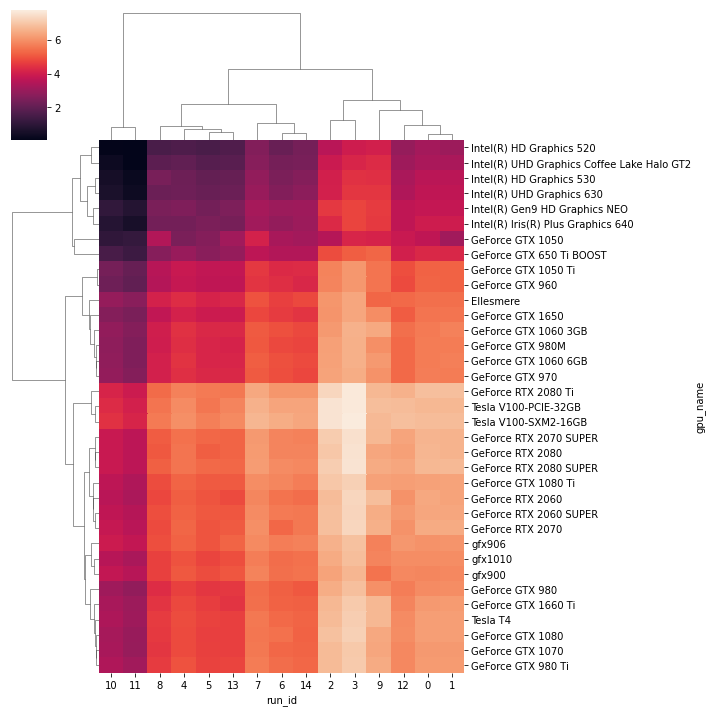

In [14]:
sns.clustermap(
    data
    .groupby('gpu_name').filter(lambda x: len(x.groupby('run_id')) == 15)
    .groupby(['run_id', 'gpu_name'])
    ['ns_per_day']
    .mean()
    .pipe(lambda x: np.log(x))
    .unstack('run_id'))